In [20]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import os
from datetime import datetime


from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#data location path
PROJECT_DIR = r"D:\CA2_Data"

TRAIN_DIR = os.path.join(PROJECT_DIR, "Train")
VALIDATION_DIR = os.path.join(PROJECT_DIR, "Validation")
LOG_DIR = os.path.join(PROJECT_DIR, "Log")
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())

seed        = 29
np.random.seed(seed)

In [21]:
train_file_count = sum([len(files) for r, d, files in os.walk(TRAIN_DIR)])
test_file_count = sum([len(files) for r, d, files in os.walk(VALIDATION_DIR)])
print("Training images: ", train_file_count)
print("Validation images: ", test_file_count)

Training images:  2423
Validation images:  724


# Setup Model

In [22]:
# resLyr
def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):
    convLyr = Conv2D(numFilters,
                       kernel_size=kernelSz,
                       strides=strides,
                       padding='same',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4),
                       name=lyrName+'_conv' if lyrName else None)
    x = inputs
    if convFirst:
        x = convLyr(x)
        if batchNorm:
            x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation,name=lyrName+'_'+activation if lyrName else None)(x)
    else:
        if batchNorm:
            x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation,name=lyrName+'_'+activation if lyrName else None)(x)
        x = convLyr(x)

    return x

# resBlkV1
def resBlkV1(inputs,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=True,
             names=None):
    x = inputs
    
    for run in range(0,numBlocks):
        strides = 1
        blkStr = str(run+1)

        if downsampleOnFirst and run == 0:
            strides = 2

        y = resLyr(inputs=x,
                   numFilters=numFilters,
                   strides=strides,
                   lyrName=names+'_Blk'+blkStr+'_Res1' if names else None)
        y = resLyr(inputs=y,
                   numFilters=numFilters,
                   activation=None,
                   lyrName=names+'_Blk'+blkStr+'_Res2' if names else None)
        
        if downsampleOnFirst and run == 0:
            x = resLyr(inputs=x,
                        numFilters=numFilters,
                        kernelSz=1,
                        strides=strides,
                        activation=None,
                        batchNorm=False,
                        lyrName=names+'_Blk'+blkStr+'_lin' if names else None)
            
        x = add([x,y],name=names+'_Blk'+blkStr+'_add' if names else None)
        x = Activation('relu',name=names+'_Blk'+blkStr+'_relu' if names else None)(x)

    return x

In [23]:
img_rows = 32
img_cols = 32
epochs = 80
batch_size = 32

optmz       = optimizers.Adam(lr=0.001)
modelname   = 'Model_v1.3' 

LOG_DIR = os.path.join(PROJECT_DIR, modelname)

In [24]:
# createResNetV1
def createResNetV1(inputShape=(img_rows,img_cols,3),
                   numClasses=3):
    inputs = Input(shape=inputShape)
    v = resLyr(inputs, lyrName='Inpt')
    v = resBlkV1(v,16,3,False,'Stg1')
    v = resBlkV1(v,32,3,True,'Stg2')
    v = resBlkV1(v,64,3,True,'Stg3')

    v = AveragePooling2D(pool_size=4,name='AvgPool')(v)
    v = Flatten()(v)
    outputs = Dense(numClasses,activation='softmax',kernel_initializer='he_normal')(v)
    model = Model(inputs=inputs,outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                    optimizer=optmz,
                    metrics=['accuracy'])

    return model

# set up model
model       = createResNetV1()  # This is meant for training
modelGo     = createResNetV1()  # This is used for final testing

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Inpt_conv (Conv2D)              (None, 32, 32, 16)   448         input_7[0][0]                    
__________________________________________________________________________________________________
Inpt_bn (BatchNormalization)    (None, 32, 32, 16)   64          Inpt_conv[0][0]                  
__________________________________________________________________________________________________
Inpt_relu (Activation)          (None, 32, 32, 16)   0           Inpt_bn[0][0]                    
____________________________________________________________________________________________

## Fina Tune Model

In [25]:
# Create checkpoint for the training
filepath        = os.path.join(PROJECT_DIR, modelname + ".hdf5")
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

# Log the epoch detail into csv
csv_logger      = CSVLogger(os.path.join(PROJECT_DIR,  modelname +'.csv'))
callbacks_list  = [checkpoint,csv_logger]

## Create Image Data Generator

In [26]:
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                        target_size=(img_rows, img_cols), 
                                                        batch_size=batch_size, shuffle=False)

Found 2423 images belonging to 3 classes.
Found 724 images belonging to 3 classes.


# Train Model

In [27]:
history = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=epochs, 
                    verbose=1,
                    workers=8,
                    steps_per_epoch=train_generator.n//batch_size,
                    validation_steps=validation_generator.n//batch_size,
                    callbacks=callbacks_list)

Epoch 1/80
75/75 [==============================] - 18s 242ms/step - loss: 0.9870 - acc: 0.6512 - val_loss: 10.5526 - val_acc: 0.2699
Epoch 2/80
75/75 [==============================] - 3s 35ms/step - loss: 0.6906 - acc: 0.7767 - val_loss: 2.6891 - val_acc: 0.4815
Epoch 3/80
75/75 [==============================] - 3s 38ms/step - loss: 0.5606 - acc: 0.8331 - val_loss: 1.1223 - val_acc: 0.6222
Epoch 4/80
75/75 [==============================] - 2s 29ms/step - loss: 0.4268 - acc: 0.8967 - val_loss: 1.4330 - val_acc: 0.5824
Epoch 5/80
75/75 [==============================] - 3s 38ms/step - loss: 0.3227 - acc: 0.9448 - val_loss: 0.7503 - val_acc: 0.7798
Epoch 6/80
75/75 [==============================] - 2s 29ms/step - loss: 0.2736 - acc: 0.9631 - val_loss: 1.4200 - val_acc: 0.6719
Epoch 7/80
75/75 [==============================] - 2s 29ms/step - loss: 0.2248 - acc: 0.9795 - val_loss: 0.9131 - val_acc: 0.7798
Epoch 8/80
75/75 [==============================] - 2s 29ms/step - loss: 0.2249 

75/75 [==============================] - 2s 31ms/step - loss: 0.1024 - acc: 1.0000 - val_loss: 0.7625 - val_acc: 0.8480
Epoch 63/80
75/75 [==============================] - 3s 36ms/step - loss: 0.1003 - acc: 1.0000 - val_loss: 0.7566 - val_acc: 0.8452
Epoch 64/80
75/75 [==============================] - 3s 37ms/step - loss: 0.0985 - acc: 1.0000 - val_loss: 0.9249 - val_acc: 0.8224
Epoch 65/80
75/75 [==============================] - 3s 33ms/step - loss: 0.1038 - acc: 0.9967 - val_loss: 1.3851 - val_acc: 0.7940
Epoch 66/80
75/75 [==============================] - 3s 34ms/step - loss: 0.6089 - acc: 0.8350 - val_loss: 15.4712 - val_acc: 0.2756
Epoch 67/80
75/75 [==============================] - 3s 35ms/step - loss: 0.3325 - acc: 0.9262 - val_loss: 1.2890 - val_acc: 0.6520
Epoch 68/80
75/75 [==============================] - 3s 35ms/step - loss: 0.1818 - acc: 0.9778 - val_loss: 0.6045 - val_acc: 0.8679
Epoch 69/80
75/75 [==============================] - 2s 28ms/step - loss: 0.1440 - acc:

# Model Evaluation

## Comparison between Training and Validation Dataset for Accuracy and Loss

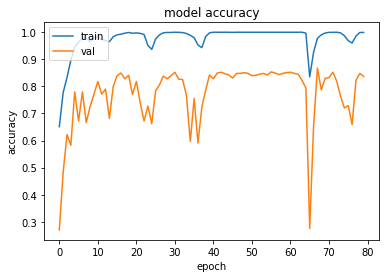

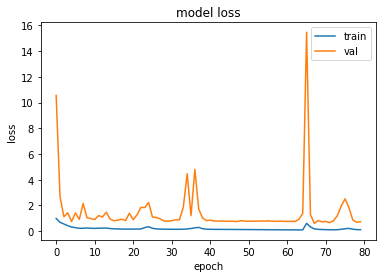

In [28]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Confusion Matrix

In [29]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, steps=np.math.ceil(validation_generator.samples/validation_generator.batch_size), verbose=1, workers=0)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

23/23 [==============================] - 2s 88ms/step
Confusion Matrix
[[252  24  21]
 [ 14 184  20]
 [ 16  24 169]]


## Classification Report

In [30]:
target_names = list(validation_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

    food_resize       0.89      0.85      0.87       297
landmark_resize       0.79      0.84      0.82       218
  people_resize       0.80      0.81      0.81       209

       accuracy                           0.84       724
      macro avg       0.83      0.83      0.83       724
   weighted avg       0.84      0.84      0.84       724



# Plot Model

In [31]:
from tensorflow.keras.utils import plot_model

plot_model(model, 
           to_file=os.path.join(PROJECT_DIR, modelname+'_model.png'), 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
